# Spotify Cold Start Models
Seth Billiau, William Drew, Sarah Lucioni


## k-NN and k-Means Clustering Models

Our first set of models are k-Nearest Neighbor based models. These models exhibit a more tailored playlist. Our next set of models are k-Means Clustering based models. These exhibit a more computer selected playlist. By creating both sets of models, we will be able to test "human selection" vs. "computer selection."

We will evaluate each song by it's audio features determined via the Spotify API. The audio features we will use are:

- acousticness
- danceability
- energy
- instrumentalness
- liveness
- speechiness
- tempo

Spotify normalizes all values except tempo. 

The model variations we will explore include: 
- (**distance metric**) euclidean distance vs. cosine similarity
- (**tempo variations**) raw tempo vs. not using tempo  

In [58]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pickle

First, we need to initiate access to the Spotify API. We need to set our API keys and set up authentication with the API.

In [3]:
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
def initiate_api():    
    client_id = "9cd3dd2ea2cf492ca28ab0247a79d781"
    client_secret = "11c972ad002843e9be5ecc31f022dd6e"
    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}
    url = 'https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (client_id, client_secret)) 
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp = initiate_api()

Let's now load the song data that we will use to train our models.

In [4]:
songs_df = pd.read_pickle("william/pickles/songs_30k_dropped.pkl")
songs_df.head()

,index,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,0.03110,https://api.spotify.com/v1/audio-analysis/0UaM...,0.904,226864,0.813,0UaMYEvWZi0ZqiDOoHU3YI,0.006970,4,0.0471,-7.105,0,0.1210,125.461,4,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,audio_features,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0.810
1,1,0.02490,https://api.spotify.com/v1/audio-analysis/6I9V...,0.774,198800,0.838,6I9VzXrHxO9rA9A5euc8Ak,0.025000,5,0.2420,-3.914,0,0.1140,143.040,4,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,audio_features,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,0.924
2,2,0.00238,https://api.spotify.com/v1/audio-analysis/0WqI...,0.664,235933,0.758,0WqIKmW4BTrj3eJFmnCKMv,0.000000,2,0.0598,-6.583,0,0.2100,99.259,4,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,audio_features,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0.701
3,3,0.20200,https://api.spotify.com/v1/audio-analysis/1AWQ...,0.891,267267,0.714,1AWQoqb9bSvzTjaLralEkT,0.000234,4,0.0521,-6.055,0,0.1400,100.972,4,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,audio_features,spotify:track:1AWQoqb9bSvzTjaLralEkT,0.818
4,4,0.05610,https://api.spotify.com/v1/audio-analysis/1lzr...,0.853,227600,0.606,1lzr43nnXAijIGYnCT8M8H,0.000000,0,0.3130,-4.596,1,0.0713,94.759,4,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,audio_features,spotify:track:1lzr43nnXAijIGYnCT8M8H,0.654


In [5]:
cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
cols_no_tempo = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
songs_df_w_features = songs_df[cols]
songs_df_no_tempo = songs_df[cols_no_tempo]

## k-NN Models

Our k-NN models will have two variants: metric and tempo. This leads to four k-NN models total. The four models are:

- k-NN using Euclidean distance and tempo
- k-NN using Euclidean distance and no tempo
- k-NN using Cosine Similarity and tempo
- k-NN using Cosine Similarity and no tempo

We decided to only look at raw tempo vs. no tempo values instead of also trying to normalize tempo. We came to this conclusion after testing normalized tempo and saw that the playlists typically consisted of songs with missing audio features. This created a lot of issues while trying to test, so we decided to omit normalization of tempo.

The **knn** function below is our general k-NN model. 

In [6]:
def knn(songs_df, seed_song, n, metric="euclid", tempo=False):
    '''
    inputs:
        songs_df : dataframe of the audio features of all songs 
        seed_song : the uri of the seed song 
        n : length of desired playlist
        metric : string, "dist" or "sim" for euclidean distance or cosine similarity as the distance metric
        tempo : whether or not tempo should be included
    outputs:
        dist : pandas Series with 
    '''
    cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
    cols_no_tempo = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
    
    seed_song = pd.DataFrame(sp.audio_features(seed_song))

    # Calculate distance using the desired metric
    if metric == "sim":
        if tempo:
            dist = cosine_similarity(np.asarray(songs_df[cols]), np.asarray(seed_song[cols]))
        else:
            dist = cosine_similarity(np.asarray(songs_df[cols_no_tempo]), np.asarray(seed_song[cols_no_tempo]))
            
        dist = pd.Series(dist.reshape(-1,))
        topn_dist = dist.sort_values(ascending=False)[0:n]
    else:
        if tempo:
            dist = euclidean_distances(np.asarray(songs_df[cols]), np.asarray(seed_song[cols]))
        else:
            dist = euclidean_distances(np.asarray(songs_df[cols_no_tempo]), np.asarray(seed_song[cols_no_tempo]))
            
        dist = pd.Series(dist.reshape(-1,))
        topn_dist = dist.sort_values()[0:n]
    
    topn = topn_dist.index
    return topn

In [7]:
def playlist_printer(ids, songs_df, kmeans=False):
    '''
    print out the playlist from song indexes and return the audio features of the playlist
    
    inputs:
        ids : list of song indexes in df
        songs_df : dataframe containing songs
    output: 
        playlist_features : dataframe of the audio features of the playlist
    '''
    cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
    playlist_features = pd.DataFrame(columns = cols)
    
    for i in ids:
        if kmeans:
            track_uri = songs_df.loc[i].id
        else:
            track_uri = songs_df.iloc[i].id
        track = sp.track(track_uri)
        print(track['name'])
        print('by')
        for artist in track['artists']:
            print(artist['name'])
        print('-----------------------------------')
        
        playlist_features = playlist_features.append(pd.DataFrame(sp.audio_features(track_uri))[cols])
        
    return playlist_features

Below, we use the above **knn** function to define each of our four k-NN models.

In [8]:
'''
run the model stated by the name

inputs: 
    songs_df : dataframe containing songs
    seed_song : the uri of the seed song
    n : length of desired playlist
output:
    mean audio features of the playlist
'''

def knn_euclid_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="euclid", tempo=True)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_euclid_no_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="euclid", tempo=False)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_sim_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="sim", tempo=True)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

def knn_sim_no_tempo(songs_df, seed_song, n):
    topn_ids = knn(songs_df, seed_song, n, metric="sim", tempo=False)
    pf = playlist_printer(topn_ids, songs_df)
    return pf.describe().loc["mean"]

In [9]:
def run_all_knn(songs_df, seed_song, n):
    '''
    run all of the k-NN models, print each model type and playlist, return a dataframe of the 
    audio feature means of each playlist created by each model
    
    inputs:
        songs_df : dataframe containing songs
        seed_song : the uri of the seed song
        n : length of desired playlist
    output:
        means_df : dataframe of the audio feature means of each playlist created by each model
    '''
    print("k-NN, euclidean distance, tempo included")
    print("****************************************")
    mean_knn_euclid_tempo = knn_euclid_tempo(songs_df, seed_song, n)
    
    print("\nk-NN, euclidean distance, tempo NOT included")
    print("****************************************")
    mean_knn_euclid_no_tempo = knn_euclid_no_tempo(songs_df, seed_song, n)
    
    
    print("\nk-NN, cosine similarity, tempo included")
    print("****************************************")
    mean_knn_sim_tempo = knn_sim_tempo(songs_df, seed_song, n)
    
    print("\nk-NN, cosine similarity, tempo NOT included")
    print("****************************************")
    mean_knn_sim_no_tempo = knn_sim_no_tempo(songs_df, seed_song, n)
    
    
    means_df = pd.concat([mean_knn_euclid_tempo, mean_knn_euclid_no_tempo, 
                          mean_knn_sim_tempo, mean_knn_sim_no_tempo], 
                         axis=1)
    means_df = means_df.transpose()
    means_df = means_df.append(pd.DataFrame(sp.audio_features(seed_song))[["acousticness", "danceability", 
                                                                           "energy", "instrumentalness", 
                                                                           "liveness", "speechiness", "tempo"]])
    means_df.index = ["k-NN/euclid/tempo", "k-NN/euclid/no tempo", "k-NN/sim/tempo", "k-NN/sim/no tempo", "seed song"]
    means_df = means_df.fillna(0)
    return means_df

In [135]:
# Charlie Puth, Senorita = "0TK2YIli7K1leLovkQiNik"
# Yo-Yo Ma, Cello Suite No. 1 in G Major = "61dYvvfIRtIDFuqZypPAta"
# Mariah Carey, All I Want for Christmas is You = "1bCQIvugIRkL0yLG5cvQcZ"
# Michael Bublé, It's Beginning to Look a lot Like Christmas = "5a1iz510sv2W9Dt1MvFd5R"

run_all_knn(songs_df, "0bYg9bo50gSsH3LtXe2SQn", 5)

k-NN, euclidean distance, tempo included
****************************************
All I Want for Christmas Is You
by
Mariah Carey
-----------------------------------
Angels
by
Robbie Williams
-----------------------------------
Right Now
by
HAIM
-----------------------------------
Point of View
by
Silverchair
-----------------------------------
Take It Out
by
Finish Ticket
-----------------------------------

k-NN, euclidean distance, tempo NOT included
****************************************
All I Want for Christmas Is You
by
Mariah Carey
-----------------------------------
The End (feat. Lights)
by
Silverstein
Lights
-----------------------------------
Marble Steps
by
Bonnie McKee
-----------------------------------
Troublemaker
by
Beach House
-----------------------------------
The Whistler - 2003 Remaster
by
Jethro Tull
-----------------------------------

k-NN, cosine similarity, tempo included
****************************************
All I Want for Christmas Is You
by
Mariah Car

//anaconda3/envs/109a/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
k-NN/euclid/tempo,0.16138,0.3940,0.6360,0.0,0.10076,0.03766,150.2612
k-NN/euclid/no tempo,0.16240,0.3378,0.6206,0.0,0.07900,0.04058,144.5940
k-NN/sim/tempo,0.17460,0.3608,0.6668,0.0,0.08526,0.04026,162.1132
k-NN/sim/no tempo,0.16020,0.3788,0.6772,0.0,0.07696,0.04168,164.9740
seed song,0.16400,0.3350,0.6250,0.0,0.07080,0.03860,150.2770


## k-Means Clustering

k-Means Clustering is an unsupervised machine learning algorithm which aims to split *n* observations (songs) into *k* clusters based on the nearest mean. We will have two k-Means Clustering models: one using tempo, a second which omits tempo.

In [11]:
def kmeans(k, songs_df, seed_song, n, tempo=False, kmeans=None):
    '''
    Given a seed song (track_uri), predict a playlist of n song indexes
    
    inputs:
        k : number of clusters
        songs_df : k-means clustering model
        seed_song : the uri of the seed song 
        n : number of songs in playlist
        tempo : whether or not tempo should be included
    outputs:
        playlist_ids : list of n song indexes in the dataframe which is the playlist
        kmeans : the kmeans model that was fit on the songs_df
    '''
    # If a kmeans model already exists, do not refit a new model
    if tempo:
        cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo"]
        songs_af = songs_df[cols]
        if not kmeans:
            kmeans = KMeans(k).fit(songs_af)
    else:
        cols = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness"]
        songs_af = songs_df[cols]
        if not kmeans:
            kmeans = KMeans(k).fit(songs_af)
        
    songs_w_cluster = songs_af.copy()
    songs_w_cluster["cluster"] = kmeans.predict(songs_af)   
    
    seed_song = pd.DataFrame(sp.audio_features(seed_song))
    pred_cluster = kmeans.predict(seed_song[cols])[0]
    pred_cluster_songs = songs_w_cluster[songs_w_cluster == pred_cluster]
    
    playlist_ids = random.sample(list(pred_cluster_songs.index), n)
    
    return playlist_ids, kmeans

In [88]:
# Two variables to store each kmeans model
kmeans_t = None
kmeans_nt = None

def reset_models():
    global kmeans_t
    global kmeans_nt
    
    kmeans_t = None
    kmeans_nt = None

In [13]:
def kmeans_tempo(k, songs_df, seed_song, n):
    global kmeans_t

    if not kmeans_t:
        topn_ids, kmeans_t = kmeans(k, songs_df, seed_song, n, tempo=True)
    else:
        topn_ids, kmeans_t = kmeans(k, songs_df, seed_song, n, tempo=True, kmeans=kmeans_t)
        
    pf = playlist_printer(topn_ids, songs_df, True)
    return pf.describe().loc["mean"]

def kmeans_no_tempo(k, songs_df, seed_song, n):
    global kmeans_nt
    
    if not kmeans_nt:
        topn_ids, kmeans_nt = kmeans(k, songs_df, seed_song, n, tempo=False)
    else:
        topn_ids, kmeans_nt = kmeans(k, songs_df, seed_song, n, tempo=False, kmeans=kmeans_nt)
        
    pf = playlist_printer(topn_ids, songs_df, True)
    return pf.describe().loc["mean"]

In [14]:
def run_all_kmeans(k, songs_df, seed_song, n):
    print("k-Means, k = {}, tempo included".format(k))
    print("****************************************")
    mean_kmeans_tempo = kmeans_tempo(k, songs_df, seed_song, n)
    
    print("\nk-Means, k = {}, tempo NOT included".format(k))
    print("****************************************")
    mean_kmeans_no_tempo = kmeans_no_tempo(k, songs_df, seed_song, n)
    
    means_df = pd.concat([mean_kmeans_tempo, mean_kmeans_no_tempo], axis=1)
    means_df = means_df.transpose()
    means_df = means_df.append(pd.DataFrame(sp.audio_features(seed_song))[["acousticness", "danceability", 
                                                                           "energy", "instrumentalness", 
                                                                           "liveness", "speechiness", "tempo"]])
    means_df.index = ["k-means/k={}/tempo".format(k), "k-means/k={}/no tempo".format(k), "seed song"]
    means_df = means_df.fillna(0)
    return means_df

In [136]:
# Charlie Puth, Senorita = "0TK2YIli7K1leLovkQiNik"
# Yo-Yo Ma, Cello Suite No. 1 in G Major = "61dYvvfIRtIDFuqZypPAta"
# Mariah Carey, All I Want for Christmas is You = "1bCQIvugIRkL0yLG5cvQcZ"
# Michael Bublé, It's Beginning to Look a lot Like Christmas = "5a1iz510sv2W9Dt1MvFd5R"

run_all_kmeans(50, songs_df, "0bYg9bo50gSsH3LtXe2SQn", 5)
# Call reset_models() then run_all_kmeans to create new models

k-Means, k = 50, tempo included
****************************************
Fortune - Live Spotify Berlin
by
William Fitzsimmons
-----------------------------------
Today's the Day
by
America
-----------------------------------
Stay Low
by
Ryn Weaver
-----------------------------------
God Delights In You
by
Sovereign Grace Music
-----------------------------------
One Still Night
by
Sovereign Grace Music
-----------------------------------

k-Means, k = 50, tempo NOT included
****************************************
No Way Back
by
8mm
-----------------------------------
Next to Me
by
Southpaw Swade
Xavier Omär
-----------------------------------
Autumn Leaves - Deluxe Edition
by
Ed Sheeran
-----------------------------------
Blowback
by
Galimatias
-----------------------------------
Bear Witness
by
Pangaea
-----------------------------------


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo
k-means/k=50/tempo,0.437360,0.5030,0.5794,0.013199,0.25742,0.03848,107.0352
k-means/k=50/no tempo,0.244514,0.6546,0.5008,0.188900,0.17708,0.07976,116.2952
seed song,0.164000,0.3350,0.6250,0.000000,0.07080,0.03860,150.2770


## Visualizations

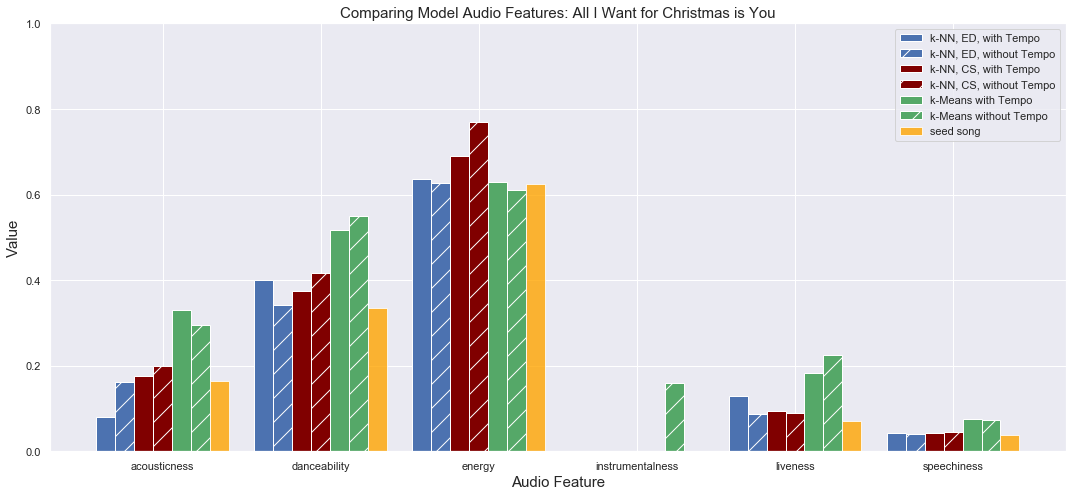

In [134]:
# Vis for:
# Michael Bublé, It's Beginning to Look a lot Like Christmas
# Yo-Yo Ma, Cello Suite No. 1 in G Major = "61dYvvfIRtIDFuqZypPAta"
# Despacito, Luis Fonsi = "6habFhsOp2NvshLv26DqMb"
# Star Wars = "3UqSTlEwO5spY8YL3GfQGv"
# All I Want for Christmas is You = "0bYg9bo50gSsH3LtXe2SQn"

objects = ("acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness")

# data to plot
mean_kmeans_t = list(mean_df.iloc[0, 0:6])
mean_kmeans_nt = list(mean_df.iloc[1, 0:6])

mean_knn_et = list(k_nn_mean_df.iloc[0, 0:6])
mean_knn_ent = list(k_nn_mean_df.iloc[1, 0:6])
mean_knn_ct = list(k_nn_mean_df.iloc[2, 0:6])
mean_knn_cnt = list(k_nn_mean_df.iloc[3, 0:6])

seed_song_af = list(mean_df.iloc[2, 0:6])

# create plot
plt.figure(figsize=(15,7))
plt.ylim((0, 1))
index = np.arange(6)
bar_width = 0.12
opacity = 0.8

plt.bar(index, mean_knn_et, bar_width, color='b', label='k-NN, ED, with Tempo')

plt.bar(index + bar_width, mean_knn_ent, bar_width, color='b', label='k-NN, ED, without Tempo', hatch='/')

plt.bar(index + 2*bar_width, mean_knn_ct, bar_width, color='maroon', label='k-NN, CS, with Tempo')

plt.bar(index + 3*bar_width, mean_knn_cnt, bar_width, color='maroon', label='k-NN, CS, without Tempo', hatch='/')

plt.bar(index + 4*bar_width, mean_kmeans_t, bar_width, color='g', label='k-Means with Tempo')

plt.bar(index + 5*bar_width, mean_kmeans_nt, bar_width, color='g', label='k-Means without Tempo', hatch="/")

plt.bar(index + 6*bar_width, seed_song_af, bar_width, alpha=opacity, color='orange', label='seed song')

plt.xlabel('Audio Feature', size=15)
plt.ylabel('Value', size=15)
plt.title("Comparing Model Audio Features: All I Want for Christmas is You", size=15)
plt.xticks(index + 3*bar_width, objects)
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
evals_df = pd.read_csv('evals.csv')

,Country Girl (Shake It For Me),Ransom,Magnolia,FACE,Inside Out,Lovebug,My Shot,Moments Passed,Come Down,Emaline,Say It Ain't So,Der Geist hilft unser Schwachheit auf,Vossi Bop,The Thrill is Gone,How Far I'll Go,My Oh My,Posthumous Forgiveness,Desperado,Sir Duke,Happy Birthday
0,0.001753,0.008899,0.094286,0.020528,0.028865,0.005819,0.004700,0.004245,0.028447,0.010707,0.010820,0.039614,0.000341,0.002741,0.000447,0.002860,0.038095,0.059450,0.004620,0.002366
1,0.000153,0.000216,0.000410,0.005342,0.000131,0.000600,0.000320,0.000423,0.001110,0.000139,0.000138,0.001006,0.029178,0.029912,0.006570,0.000111,0.001118,0.000149,0.000589,0.000236
2,0.002200,0.002312,0.001734,0.051708,0.008655,0.059192,0.000535,0.028958,0.020129,0.000105,0.000593,0.004548,0.001237,0.058425,0.005086,0.009427,0.007383,0.002446,0.013601,0.005628
3,0.009898,0.004695,0.000132,0.083133,0.002886,0.028596,0.000413,0.015484,0.058544,0.000044,0.022434,0.005444,0.006090,0.055224,0.011233,0.002148,0.049842,0.000684,0.033783,0.003489
4,0.200039,0.272664,0.252121,0.272206,0.218657,0.103388,0.179155,0.132276,0.180081,0.237566,0.202545,0.698867,0.119955,0.147720,0.219445,0.148766,0.230584,0.733834,0.043316,0.488781
5,0.193183,0.240512,0.267089,0.239928,0.239411,0.116032,0.239149,0.145516,0.157483,0.137893,0.169659,0.637459,0.166315,0.132937,0.334911,0.160077,0.286806,0.723697,0.056422,0.392939


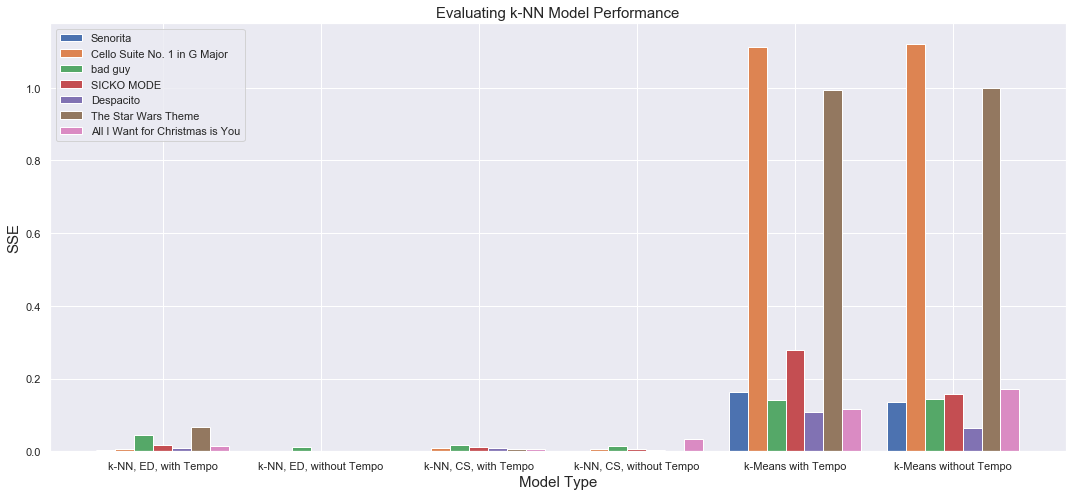

In [128]:
# Errors vis
objects = ("k-NN, ED, with Tempo", "k-NN, ED, without Tempo", "k-NN, CS, with Tempo", "k-NN, CS, without Tempo", 
           "k-Means with Tempo", "k-Means without Tempo")
# objects = ("k-Means with Tempo", "k-Means without Tempo")
# data to plot
senorita = list(evals_df.iloc[0:6, 1])
yoyo = list(evals_df.iloc[0:6, 2])
bad_guy = list(evals_df.iloc[0:6, 4])
sickko_mode = list(evals_df.iloc[0:6, 5])
despacito = list(evals_df.iloc[0:6, 6])
star_wars = list(evals_df.iloc[0:6, 13])
all_i_want_for_xmas = list(evals_df.iloc[0:6, 15])

# create plot
plt.figure(figsize=(15,7))
index = np.arange(6)
bar_width = 0.12
opacity = 0.8

plt.bar(index, senorita[0:6], bar_width, label='Senorita')

plt.bar(index + bar_width, yoyo[0:6], bar_width, label='Cello Suite No. 1 in G Major')

plt.bar(index + 2*bar_width, bad_guy[0:6], bar_width, label='bad guy')

plt.bar(index + 3*bar_width, sickko_mode[0:6], bar_width, label='SICKO MODE')

plt.bar(index + 4*bar_width, despacito[0:6], bar_width, label='Despacito')

plt.bar(index + 5*bar_width, star_wars[0:6], bar_width, label='The Star Wars Theme')

plt.bar(index + 6*bar_width, all_i_want_for_xmas[0:6], bar_width, label='All I Want for Christmas is You')

plt.xlabel('Model Type', size=15)
plt.ylabel('SSE', size=15)
plt.title('Evaluating k-NN Model Performance', size=15)
plt.xticks(index + 3*bar_width, objects)
plt.legend()

plt.tight_layout()
plt.show()

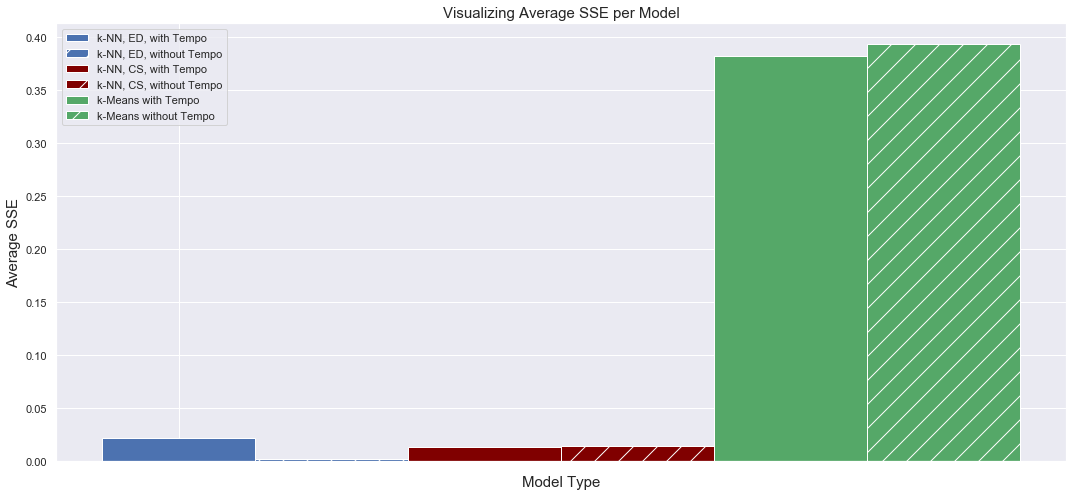

In [144]:
# Errors vis
objects = ("k-NN, ED, with Tempo", "k-NN, ED, without Tempo", "k-NN, CS, with Tempo", "k-NN, CS, without Tempo", 
           "k-Means with Tempo", "k-Means without Tempo")
# objects = ("k-Means with Tempo", "k-Means without Tempo")
# data to plot

# create plot
plt.figure(figsize=(15,7))
index = np.arange(1)
bar_width = 0.12
opacity = 0.8

plt.bar(index, 0.022173, bar_width, color='b', label='k-NN, ED, with Tempo')

plt.bar(index + bar_width, 0.002360, bar_width, color='b', label='k-NN, ED, without Tempo', hatch='/')

plt.bar(index + 2*bar_width, 0.013097, bar_width, color='maroon', label='k-NN, CS, with Tempo')

plt.bar(index + 3*bar_width, 0.014297, bar_width, color='maroon', label='k-NN, CS, without Tempo', hatch='/')

plt.bar(index + 4*bar_width, 0.382007, bar_width, color='g', label='k-Means with Tempo')

plt.bar(index + 5*bar_width, 0.393498, bar_width, color='g', label='k-Means without Tempo', hatch="/")

plt.xlabel('Model Type', size=15)
plt.ylabel('Average SSE', size=15)
plt.title('Visualizing Average SSE per Model', size=15)
plt.xticks(index, [])
plt.legend()

plt.tight_layout()
plt.show()